# <center> Database Management Project: <br> Recommender System in Spark using ALS for implicit Feedback </center>
<center><b>Tommy Tran, Thomas de Mareuil, Constantin Vodé - March 2020 </b></center>

This project is based on the paper "Fast Matrix Factorization for Online Recommendation with Implicit Feedback" by H. Xiangnan _et al._ , National University of Singapore, published at SIGIR '16, July 2016, Pisa (Italy), and available through this [link](https://www.comp.nus.edu.sg/~xiangnan/papers/sigir16-eals-cm.pdf).

The data we use in this project is a dataset recommended in the paper, comprising 78.930 reviews for Cell phones & Accesories on Amazon, collected by Stanford's Jure Leskovec, PhD, and available through this [link](http://snap.stanford.edu/data/web-Amazon-links.html).

We start by parsing the dataset and loading it in Spark to explore it. Then we implement the regular ALS method for matrix factorization, and the more efficient eALS method presented in the paper. In these steps, we implement from scratch the algortihms presented in the paper and we adapt them to Spark (`PySpark`). In the final section, we implement ALS matrix factorization again but using PySpark's existing ALS library, and we test it on our dataset.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parsing,-loading-and-exploring-the-data-in-Spark" data-toc-modified-id="Parsing,-loading-and-exploring-the-data-in-Spark-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parsing, loading and exploring the data in Spark</a></span><ul class="toc-item"><li><span><a href="#Parsing-the-Data" data-toc-modified-id="Parsing-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parsing the Data</a></span></li><li><span><a href="#Loading-the-data-in-Spark" data-toc-modified-id="Loading-the-data-in-Spark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loading the data in Spark</a></span></li><li><span><a href="#Data-exploration-with-Spark" data-toc-modified-id="Data-exploration-with-Spark-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data exploration with Spark</a></span><ul class="toc-item"><li><span><a href="#Getting-insights-from-the-data-with-Spark-queries" data-toc-modified-id="Getting-insights-from-the-data-with-Spark-queries-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Getting insights from the data with Spark queries</a></span></li><li><span><a href="#Extracting-rating-data-as-an-RDD-for-further-analysis" data-toc-modified-id="Extracting-rating-data-as-an-RDD-for-further-analysis-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Extracting rating data as an RDD for further analysis</a></span></li></ul></li></ul></li><li><span><a href="#Our-implemention-of-the-ALS-matrix-factorization-algorithm-in-Spark" data-toc-modified-id="Our-implemention-of-the-ALS-matrix-factorization-algorithm-in-Spark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Our implemention of the ALS matrix factorization algorithm in Spark</a></span></li><li><span><a href="#Our-implemention-of-the-eALS-algorithm-for-fast-matrix-factorization-in-Spark" data-toc-modified-id="Our-implemention-of-the-eALS-algorithm-for-fast-matrix-factorization-in-Spark-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Our implemention of the eALS algorithm for fast matrix factorization in Spark</a></span><ul class="toc-item"><li><span><a href="#RMSE" data-toc-modified-id="RMSE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RMSE</a></span></li></ul></li><li><span><a href="#Recommender-system-using-the-existing-ALS-implementation-in-PySpark" data-toc-modified-id="Recommender-system-using-the-existing-ALS-implementation-in-PySpark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recommender system using the existing ALS implementation in PySpark</a></span><ul class="toc-item"><li><span><a href="#Recommender-system-with-existing-PySpark-ALS" data-toc-modified-id="Recommender-system-with-existing-PySpark-ALS-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Recommender system with existing PySpark ALS</a></span></li><li><span><a href="#Generate-top-10-product-recommendations-for-each-user" data-toc-modified-id="Generate-top-10-product-recommendations-for-each-user-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Generate top 10 product recommendations for each user</a></span></li><li><span><a href="#ALS-model-evaluation-and-selection-(grid-search)" data-toc-modified-id="ALS-model-evaluation-and-selection-(grid-search)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ALS model evaluation and selection (grid search)</a></span></li><li><span><a href="#ALS-model-learning-curve" data-toc-modified-id="ALS-model-learning-curve-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>ALS model learning curve</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
# spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.recommendation import ALS
from pyspark.ml.recommendation import ALS

# data science imports
import pandas as pd
import numpy as np
from numpy import matrix
from numpy.random import rand
from sklearn import preprocessing
import math
from math import floor

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# other imports
import sys
import time
#from __future__ import print_function
import gzip
from ast import literal_eval
import json
import simplejson

%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

## Parsing, loading and exploring the data in Spark

### Parsing the Data

In [2]:
def parse(filename):
    """
    Function to parse the "Cell Phones & Accessories Ratings" dataset (.txt format)
    """
    f = open(filename, 'r')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry


# Parsing the data

for e in parse("Cell_Phones_&_Accessories.txt"):
    a = simplejson.dumps(e)
    a = literal_eval(a)
    df = pd.DataFrame(a, index=[1,])
    df = df.drop(index=1)
    break;

i=0
for e in parse("Cell_Phones_&_Accessories.txt"):
    i+=1
    b = simplejson.dumps(e)
    b = literal_eval(b)

    b = pd.DataFrame(b, index=[1,])
    df = df.append(b, ignore_index=True)
    if i==1000:
        break;

In [3]:
# Encoding products Ids (label encoding)

le = preprocessing.LabelEncoder()
le.fit(df['product/productId'])
le.classes_
df['product/productId'] = le.transform(df['product/productId'])

# Encoding users Ids (label encoding)

le = preprocessing.LabelEncoder()
le.fit(df['review/userId'])
le.classes_
df['review/userId'] = le.transform(df['review/userId'])

In [4]:
# Saving as .csv
#df.to_csv('ratings.csv', index=False)

data = pd.read_csv('ratings.csv')
data.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,741,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,1935,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,741,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,7295,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,741,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,4031,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,372,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,3089,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,372,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,8347,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


Now that we have a useable dataset, we can load it and explore it in Spark.

### Loading the data in Spark

In [5]:
# spark config
spark = SparkSession \
    .builder \
    .appName("product recommendations") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()

# get spark context
sc = spark.sparkContext

In [6]:
ratings = spark.read.load('ratings.csv', format='csv', header=True, inferSchema=True)
ratings.show()

+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|product/productId|       product/title|product/price|review/userId|  review/profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|              741|Mobile Action MA7...|      unknown|         1935|             A. Igoe|               0/0|         1.0| 1233360000|          Don't buy!|First of all, the...|
|              741|Mobile Action MA7...|      unknown|         7295|        Steven Martz|               0/0|         5.0| 1191456000|Mobile Action Blu...|Great product- tr...|
|              741|Mobile Action MA7...|      unknown|         4031|"Daniel M. Johnso...|               0/0|         4.0

### Data exploration with Spark

#### Getting insights from the data with Spark queries

**What are the possible ratings?**

In [7]:
print('Distinct values of ratings:')
print(sorted(ratings.select('review/score').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[' & Books"""', ' and Roll!"""', ' etc."""', ' gadget guy"""', '0/0', '1.0', '1/1', '1/2', '1/3', '13/14', '15/16', '2.0', '2/3', '20/21', '3.0', '3/3', '3/4', '4.0', '5.0', '5/5', '5/6', '5/7', '6/7', '6/9', '8/11', '8/8', '9/9']


We can see that with this command we catch some elements that are not ratings. We will drop them and convert the ratings later so that they can be processed.

**What are the minimum number of ratings per user and minimum number of ratings per product?**

In [8]:
tmp1 = ratings.groupBy("review/userid").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("product/title").count().toPandas()['count'].min()
print('For the users that rated products and the products that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per product is {}'.format(tmp2))

For the users that rated products and the products that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per product is 1


We can observe that there are no unrated products in this dataset. In a real-life context, the recommender system would have to regularly adapt to new data, for example a new product added online, with no ratings yet, or a new user profile - this is known as the cold start problem. In the paper, their strategy for such cases is to use metadata for recommendations rather than explicit feedback (ratings) or implicit feedback (actions on website), and to update the model once they have more data.

**What is the total number of users in the data set?**

In [9]:
tmp3 = ratings.select('review/userid').distinct().count()
print('We have a total of {} distinct users in the data set'.format(tmp3))

We have a total of 9245 distinct users in the data set


**What is the total number of products in the data set?**

In [10]:
tmp4 = ratings.select('product/productid').distinct().count()
print('We have a total of {} distinct products in the data set'.format(tmp4))

We have a total of 976 distinct products in the data set


**What are the products with the most ratings and the users that rated the most products?**

In [11]:
# We create a temp SQL table view for easier query:
ratings.createOrReplaceTempView("ratings")
print('List of products that have the most ratings: ')

# Most rated items
spark.sql(
    "SELECT `product/productid`, `product/title`, count(`product/title`) as `number of ratings`"
    "FROM ratings "
    "GROUP BY 1, 2 ORDER BY 3 desc"
).show(10)

List of products that have the most ratings: 
+-----------------+--------------------+-----------------+
|product/productid|       product/title|number of ratings|
+-----------------+--------------------+-----------------+
|              169|Sony Ericsson T61...|              501|
|              466|Monster RadioPlay...|              410|
|              315|Motorola H500 Blu...|              409|
|              335|Motorola Lithium-...|              286|
|              392|Jabra BT500 Bluet...|              251|
|               82|Jabra EarGels - C...|              216|
|              389|Jabra C250 EarWav...|              214|
|              617|Plantronics Explo...|              186|
|              253|Motorola V600 Pho...|              160|
|              622|Cardo Systems Sca...|              155|
+-----------------+--------------------+-----------------+
only showing top 10 rows



In [12]:
# Users that rated the most products
print('List of users that rated the most products')
spark.sql(
    "SELECT `review/userId`, count(`review/userId`) as `number of items rated`"
    "FROM ratings "
    "GROUP BY 1 ORDER BY 2 desc"
).show(10)

List of users that rated the most products
+-------------+---------------------+
|review/userId|number of items rated|
+-------------+---------------------+
|         9244|                  501|
|         1889|                    6|
|         1906|                    5|
|         7221|                    5|
|         8931|                    4|
|         7148|                    4|
|         8995|                    4|
|         8467|                    4|
|         4510|                    4|
|         6779|                    4|
+-------------+---------------------+
only showing top 10 rows



#### Extracting rating data as an RDD for further analysis

In [13]:
# File location and type
file_location = "ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

rating_data = df.rdd

header = rating_data.take(1)[0]

rating_data = rating_data \
    .filter(lambda line: line!=header) \
    .map(lambda x: list(x))\
    .map(lambda x: (int(x[3]), int(x[0]), x[6].split('/')[0])) \
    .filter(lambda x: x[2]!=' and Roll!"""') \
    .filter(lambda x: x[2]!=' & Books"""') \
    .filter(lambda x: x[2]!=' etc."""') \
    .filter(lambda x: x[2]!=' gadget guy"""') \
    .map(lambda x: (x[0], x[1], float(x[2])))\
    .cache()

## Our implemention of the ALS matrix factorization algorithm in Spark

First let's write useful functions for ALS:

In [15]:
def set_data_matrix(M, data_list):
    for data in data_list:
        M[data[0], data[1]] = data[2]
    return M

def update(i, mat, ratings): # i = x, mat = V if caculate U, rating is M.
    uu = mat.shape[0]
    ff = mat.shape[1]

    XtX = mat.T * mat # projection matrix
    Xty = mat.T * ratings[i, :].T

    for j in range(ff):
        XtX[j, j] += LAMBDA * uu

    return np.linalg.solve(XtX, Xty)

def rmse(R, ms, us):
    diff = R - ms * us.T
    return np.sqrt(np.sum(np.power(diff, 2)) / (M * U)
                  )

Then let's initialize matrices and parameters for the algorithm:

In [16]:
# re-init spark
spark = SparkSession\
        .builder\
        .appName("PythonALS")\
        .getOrCreate()

sc = spark.sparkContext

In [17]:
rating_list = rating_data.collect()

LAMBDA = 0.01   # regularization

U = len(pd.read_csv('ratings.csv')['product/productId'].unique()) # nb of items
M = len(pd.read_csv('ratings.csv')['review/userId'].unique()) # nb of users
F = 8 # latent vector    
num_iters = 10
partitions = 2

R = np.full((M, U), 0, dtype=np.float64)
R = matrix(set_data_matrix(R, rating_list)) # M

users = matrix(np.full((M, F), 1.0)) # U users matrix
product = matrix(np.full((U, F), 1.0)) # V product matrix

Rb = sc.broadcast(R)
users_b = sc.broadcast(users)
product_b = sc.broadcast(product)

And now let's run the algorithm itself:

In [18]:
for i in range(num_iters):
    users = sc.parallelize(range(M), partitions) \
           .map(lambda x: update(x, product_b.value, Rb.value)) \
           .collect() # U, x = row number
    # collect() returns a list, so array ends up being
    # a 3-d array, and we take the first 2 dims for the matrix
    users = matrix(np.array(users)[:, :, 0]) # U
    users_b = sc.broadcast(users)

    product = sc.parallelize(range(U), partitions) \
           .map(lambda x: update(x, users_b.value, Rb.value.T)) \
           .collect() # V, x = columns
    product = matrix(np.array(product)[:, :, 0])
    product_b = sc.broadcast(product)

    error = rmse(R, users, product)

#print("Iteration %d:" % i)
print("R = %s\n" % (str(R))) 
print("ms = %s\n" % (str(users)))   
print("us = %s\n" % (str(product)))           
#print("\nRMSE: %5.4f\n" % error)
print("RMSE = %.4f" % error)

R = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 2. 5. ... 0. 0. 0.]]

ms = [[2.25425806e-14 2.25425806e-14 2.25425806e-14 ... 2.25425806e-14
  2.25425806e-14 2.25425806e-14]
 [1.27787654e-02 1.27787654e-02 1.27787654e-02 ... 1.27787654e-02
  1.27787654e-02 1.27787654e-02]
 [2.29777572e-03 2.29777572e-03 2.29777572e-03 ... 2.29777572e-03
  2.29777572e-03 2.29777572e-03]
 ...
 [4.59555144e-04 4.59555144e-04 4.59555144e-04 ... 4.59555144e-04
  4.59555144e-04 4.59555144e-04]
 [1.13630378e-03 1.13630378e-03 1.13630378e-03 ... 1.13630378e-03
  1.13630378e-03 1.13630378e-03]
 [4.22484105e-01 4.22484105e-01 4.22484105e-01 ... 4.22484105e-01
  4.22484105e-01 4.22484105e-01]]

us = [[6.99674285e-03 6.99674285e-03 6.99674285e-03 ... 6.99674285e-03
  6.99674285e-03 6.99674285e-03]
 [3.57073218e-03 3.57073218e-03 3.57073218e-03 ... 3.57073218e-03
  3.57073218e-03 3.57073218e-03]
 [8.76647815e-03 8.76647815e-0

##  Our implemention of the eALS algorithm for fast matrix factorization in Spark

Again, let's write the fuctions useful for eALS matric factorization. Pseudo-code (Java-like) was found in the paper mentionned in introduction to this project, and we adapt it here for Spark.

In [19]:
def set_data_matrix(M, data_list):
    for data in data_list:
        M[data[0], data[1]] = data[2]
    return M

In [28]:
def update_user(u, Uu, V, Ru, SU, SV, Wu, Wi):
    itemList = nb_items
    SU_bis = SU.value
    SV_bis = SV.value

    # prediction cache for the user
    for i in range(itemList):
        prediction_items[i] = Uu@V[i];
        rating_items[i] = Ru[i];
        w_items[i] = Wu[i]

    oldVector = Ru
    for f in range(factors):
        numer = 0
        denom = 0
        
        #O(K) complexity for the negative part
        for k in range(factors):
            if k != f:
                numer -= Uu[ k] * SV_bis[f][k]
        
        #O(Nu) complexity for the positive part
        for i in range(itemList):
            prediction_items[i] -= Uu[f] * V[i][f]
            numer +=  (w_items[i]*rating_items[i] - (w_items[i]-Wi[i]) * prediction_items[i]) * V[i][f]
            denom += (w_items[i]-Wi[i]) * V[i][f] * V[i][f]
        denom += SV_bis[f][f] + reg;

        #Parameter Update
        Uu[f] = numer / denom

        #Update the prediction cache
        for i in range(itemList):
            prediction_items[i] += Uu[f] * V[i][f]

    #Update the SU cache
    for f in range(factors):
        for k in range(factors):
            val = SU_bis[f][k] - oldVector[f] * oldVector[k] + Uu[f] * Uu[k]
            SU_bis[f][k] = val
            SU_bis[k][f] = val
    #SU = sc.broadcast(SU_bis)
    return Uu

In [48]:
def update_item(i, Vi, U, R_i, SU, SV, W_i, Wi):#W_i = W[i] #R_i = R[:][i]
    userList = nb_users
    SU_bis = SU.value
    SV_bis = SV.value

    # prediction cache for the user
    for u in range(userList):
        prediction_users[u] = U[u]@Vi
        rating_users[u] = R_i[u]
        w_users[u] = W_i[u]

    oldVector = R_i
    for f in range(factors):
        numer = 0
        denom = 0
        
        #O(K) complexity for the negative part
        for k in range(factors):
            if k != f:
                numer -= Vi[k] * SU_bis[f][k]
        

        #O(Nu) complexity for the positive part
        for u in range(userList):
            prediction_users[u] -= U[u][f] * Vi[f]
            numer +=  (w_users[u]*rating_users[u] - (w_users[i]-Wi[i]) * prediction_users[u]) * U[u][f]
            denom += (w_users[i]-Wi[i]) * U[u][f] * U[u][f]
        denom += SU_bis[f][f] + reg;

        #Parameter Update
        V[i][f] = numer / denom

        #Update the prediction cache
        for u in range(userList):
            prediction_users[u] += U[u][f] * Vi[f]

    #Update the SV cache
    for f in range(factors):
        for k in range(factors):
            val = SV_bis[f][k] - oldVector[f] * oldVector[k] * Wi[i] + Vi[f]*Vi[k]*Wi[i]
            SV_bis[f][k] = val
            SV_bis[k][f]= val
    #SV = sc.broadcast(SV_bis)
        
    return Vi

Then let's initialize the matrices and parameters we will need to run eALS:

In [49]:
#re-init spark
spark = SparkSession\
        .builder\
        .appName("Python_eALS")\
        .getOrCreate()

sc = spark.sparkContext

In [50]:
rating_list = rating_data.collect()

# Set model priors
partitions = 10
factors = 10 # number of latent factors
maxIter = 20 #maximum iterations
reg = 0.01 #regularization parameters
init_mean = 0;  # Gaussian mean for init V
init_stdev = 0.01 #Gaussian std-dev for init V
nb_items = len(pd.read_csv('ratings.csv')['product/productId'].unique()) # items
nb_users = len(pd.read_csv('ratings.csv')['review/userId'].unique()) # users

R = np.full((nb_users, nb_items), 0, dtype=np.float64)
R = matrix(set_data_matrix(R, rating_list)) # M
R = np.array(R)

In [51]:
"""
This cell assigns weights to implicit data (i.e. negative feedback),
with a weighting strategy based on item popularity and further described in the paper.
"""

# Set the Wi as a decay function w0 * pi ^ alpha
w0 = 1
s = 0 
Z = 0
alpha = 1
p = [0 for i in range(nb_items)]

for i in range(nb_items):
    p[i] = sum(R[0]!=0) # Nb of items per user
    s += p[i]
# convert p[i] to probability 
for i in range(nb_items):
    p[i] = p[i]/s;
   # p[i] = p[i]**alpha;
    Z += p[i];
# Assign weight
Wi = [0 for i in range(nb_items)];
for i in range(nb_items):
    Wi[i] = w0 * p[i] / Z;
# By default, the weight for positive instances is uniformly 1.
W = np.full((nb_users, nb_items), 0, dtype=np.float64)
for u in range(nb_users):
    for i in R[u]:
        W[u][int(i)]= 1 

In [52]:
# Init caches
prediction_users = [0 for i in range(nb_users)];
prediction_items = [0 for i in range(nb_items)];
rating_users = [0 for i in range(nb_users)];
rating_items = [0 for i in range(nb_items)];
w_users = [0 for i in range(nb_users)];
w_items = [0 for i in range(nb_items)];

# Init model parameters
users = np.random.normal(init_mean, init_stdev, 
                         nb_users*factors).reshape((nb_users,factors)) # latent vectors for users
product = np.random.normal(init_mean, init_stdev, 
                           nb_items*factors).reshape((nb_items, factors)) # latent vectors for items
SU = users.T@users
SV = np.full((factors, factors), 0, dtype=np.float64)

for f in range(factors):
    for k in range(factors):
        val = 0;
        for i in range(nb_items):
            val += product[i][f] * product[i][k]* Wi[i]
        SV[f][k] = val
        SV[k][f] = val

user_b = users
product_b = product
Rb = R
SU = sc.broadcast(SU)
SV = sc.broadcast(SV)

Finally, let's run the eALS algorithm:

In [ ]:
for v in range(maxIter):
    users = sc.parallelize(range(nb_users), partitions) \
               .map(lambda u: update_user(u, user_b[u], product_b, Rb[u], SU, SV, W[u], Wi)) \
               .collect() #u user id, 
    users_b = users
    print('ok')
    product = sc.parallelize(range(nb_items), partitions) \
               .map(lambda i: update_item(i, product_b[i], user_b, Rb[:][i], SU, SV, W[i], Wi)) \
               .collect() #V, x = columns
    product_b = product    

### RMSE

In [49]:
def rmse_bis(R, ms, us):
    diff = R - ms@us.T
    return np.sqrt(np.sum(np.power(diff, 2)) / (nb_users * nb_items))
                   
rmse_bis(R, np.matrix(users), np.matrix(product))

0.12399402466204804

We can observe that RMSE is roughly the same as with regular ALS, but an advantage of eALS is faster computation. Here, we run the algorithm locally, so computation duration is biased - but as per findings of the paper, eALS should be significantly faster than regular ALS when computing over a distributed cluster.

## Recommender system using the existing ALS implementation in PySpark

### Recommender system with existing PySpark ALS

In [11]:
ratings = spark.createDataFrame(rating_data)
(train, test) = ratings.randomSplit([0.8, 0.2]) # train-test split

# Build the recommendation model using ALS on the training data
# Note that we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="_1", itemCol="_2", ratingCol="_3",
          coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.559577899838846


### Generate top 10 product recommendations for each user

In [134]:
userRecs = model.recommendForAllUsers(10) # Compute recommendations for all users
reco = userRecs.take(1) # Take 1 user

In [136]:
data.loc[data['review/userId']==1580]

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
8167,346,Palm Treo 650 PDA Phone (AT&T),unknown,1580,"D. M. Kimura ""dmk""",11/13,3.0,1110758400,"If you have the TREO 600, DON'T UPGRADE",I have retired the 4th Treo 600 due to device ...


In [137]:
# Print top 10 recommendations for this user as a DataFrame

list_reco = str(reco[0]).split('Row(_2=')
reco_id = [int(list_reco[i].strip().replace('),', '').split(', rating=')[0]) for i in range(1, len(list_reco))]
reco_data = pd.DataFrame()

for item_id in range(len(reco_id)):
    reco_data = reco_data.append(data.loc[data['product/productId'] == reco_id[item_id]])

reco_data.groupby(['product/title', 'product/productId']).mean().drop(['review/userId', 'review/time'], 
                                            axis = 1 ).rename(columns={'review/score':'predicted rate'})

,,predicted rate
product/title,product/productId,
BlackBerry Folding Blade USB Charger,492,4.076923
"HTC S710 Vox Unlocked Smartphone with Windows Mobile 6.0, 2 MP Camera, Wi-Fi, MP3/Video Player, MicroSD Slot--U.S. Version with Warranty (Black/Silver)",968,3.900000
LG Verizon Chocolate VX8500 / VX8600 / KG90 / KG800 / KG808 / MG800C / ENV VX9900 / LX150 OEM Original Rapid Vehicle Cigarette Lighter Car Charger with IC Chip (SGCC0002911),716,4.583333
Motorola H500 Bluetooth Headset (Pumpkin Orange) [Motorola Retail Packaging],739,3.444444
"Nokia Headset with Answer,End Remote Button for Nokia 3650, 8200, 8800, 3300",50,3.695652
"Premium Scratch Resistant Screen Protector/ Guard for LG Chocolate VX8500, 2-LCD kit w/ Cleansing Cloth",766,3.260870
Replacement Lithium-ion Battery for Samsung E315/316/317,282,5.000000
SAMSUNG OEM BST524ASA BATTERY SCH-X909 SGH-T209 SGH-X495 SGH-X496 SGH-X497,289,4.181818
Sanyo RL2500 PCS Vision Ready Link Phone (Sprint),222,4.200000


### ALS model evaluation and selection (grid search)

In the next cells, we write and run a grid search function to determine the best ALS matrix factorization model. The parameters we test are the number of latent factors and the regularization coefficient.

In [26]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3", 
                      coldStartStrategy="drop")
            model = als.fit(train)
            # make prediction
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [27]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, test, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
8 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
8 latent factors and regularization = 0.05: validation RMSE is 2.816589387154773
8 latent factors and regularization = 0.1: validation RMSE is 2.7352330477000217
8 latent factors and regularization = 0.2: validation RMSE is 2.6822093319222815
10 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
10 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
10 latent factors and regularization = 0.05: validation RMSE is 2.816589387154773
10 latent factors and regularization = 0.1: validation RMSE is 2.7352330477000217
10 latent factors and regularization = 0.2: validation RMSE is 2.6822093319222815
12 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
12 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
12 latent fa

### ALS model learning curve

As a last step in our project, let's plot the learning curve of the Spark ALS model (with the best parameters selected by grid search) compared to the number of iterations over our dataset:

In [19]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3", 
                  coldStartStrategy="drop")
        model = als.fit(train)
        # make prediction
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

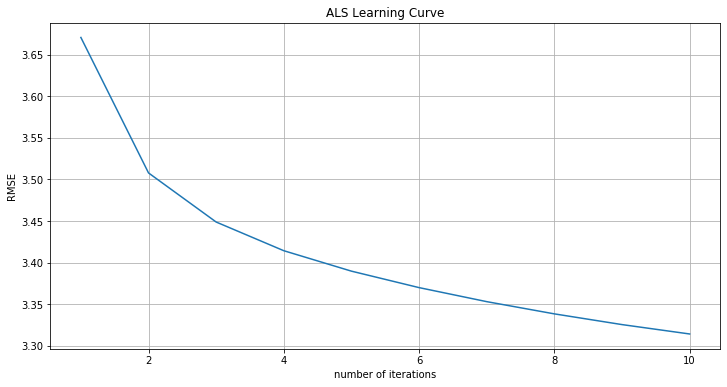

In [20]:
# create an array of num_iters
iter_array = list(range(1, 11))

# create learning curve plot with the best parameters computed above
plot_learning_curve(iter_array, train, test, 0.2, 8)

And finally let's evaluate the final model by computing the RMSE on our test data:

In [32]:
predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.6822093319222815


## Conclusion

In this project, we were able to successfully apply the algorithms presented by a research article to another dataset, and with another framework (Spark). In the course of our work, we were also able to do additional research on the topic of recommender systems, to get more familair with the topic.

To go further than this project, a possibility we see is the most recent research about Neural Networks for recommender systems. These new methods go even further than collaborative filtering and matrix factorization by leveraging embeddings of metadata and of the content itself, in order to provide even more accurate recommendations (e.g.: music recommendations based on a mix of user metadata, explicit feedback, implicit feedback and music content analysis with neural networks).

All in all, we feel like in this project we were able to apply knowledge from the Database Management course and to learn a lot personnaly - in coding, there's nothing better than learning by doing!